In [1]:
import sys
import os
import cv2
import math
import pickle
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
import face_recognition
from collections import Counter
from PIL import Image, ImageDraw, ImageFont

import os
import cv2
import glob
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class NeuralClass:

    def __init__(self, frame, percent=0.1, tolerance=0.4):

        ##self.ROOT_PATH = os.path.dirname(sys.modules['__main__'].__file__)
        self.frame = frame
        self.percent = percent
        self.tolerance = tolerance
        self.coord = []
        self.percents = []
        self.people = []
        self.utils = Utils()
        # inicializa la clase recortando, guardando las caras y descartando los frames malos
        self.COLS = ['Male', 'Asian', 'White', 'Black',  'Baby', 'Child', 'Youth', 'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair','Brown Hair', 'Bald', 'No eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling', 'Curly Hair', 'Wavy Hair', 'Straight Hair']
        self.N_UPSCLAE = 1
        self.clf, self.labels = self.getModel('../Models/race_and_gender_model.pkl')
        self.faces = self.cropper()
        self.prediction = self.clasifier()

    def getModel(self, path):

        with open(path) as f:
            clf, labels = pickle.load(f)
            return clf, labels

    def cropper(self):

        faces = list()
        frames = list()
        print("cropping")
        for frame in self.frame:
            frame_area = frame.shape[0]*frame.shape[1]
            small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
            person_loc = face_recognition.face_locations(small_frame)
            print(person_loc)
            print("Person detect: {} {} {} ".format(
                len(person_loc), person_loc[0], type(person_loc[0])))
            if(len(person_loc)):  # detecta si hay personas
                people, areas = self.utils.setDictionary(person_loc)
                # ordena las caras de mayor a menor detectadas en el frame
                people.sort(key=self.utils.sortDictionary, reverse=True)
                print("people raw", people)
                people = people[0]
                # encuentra la cara mas grande
                face_area = max(areas)
                indexMax = areas.index(face_area)
                person_location = person_loc[indexMax]
                print("dim {}".format(person_location))
                # top, rigth, bottom, left (t,r,b,l)
                t, r, b, l = self.utils.increase(
                    list(np.asarray(person_location)*4))
                percent = face_area*100/float(frame_area)
                print("percent {}%".format(percent))
                print("dim", t, r, b, l)
                if(percent >= self.percent):
                    # recortar imagenes image[y:y+h, x:x+w]
                    print("people cropper", people)
                    faces.append(frame[t:b, l:r])
                    frames.append(frame)
                    self.coord.append((t, r, b, l))
                    self.percents.append(round(percent, 2))
                    self.people.append(people)
        # guarda unicamente los frames donde hay caras
        self.frame = frames
        return faces

    def detect(self):

        if len(self.people):
            return [self.people[0]]
        return []

    def encode(self):

        person_encoding = []
        if len(self.detect()):
            for i in range(len(self.frame)):
                print self.coord[i], type(self.coord[i])
                person_encoding.append(face_recognition.face_encodings(
                    self.frame[i], [self.coord[i]])[0])
        
        print "person emcoding", person_encoding
        return person_encoding

    def compare(self, known_faces, personGroup):

        people = []
        if len(self.detect()):
            person_encoding = self.encode()[0]
            print(known_faces)
            print type(known_faces)
            print(person_encoding)
            print type(person_encoding)
            matches = face_recognition.compare_faces(known_faces, person_encoding, tolerance=self.tolerance)

            print("matches", matches)
            print("distance : ", face_recognition.face_distance(
                known_faces, person_encoding))
            if True in matches:
                first_match_index = matches.index(True)
                people = personGroup[first_match_index]
                distance = face_recognition.face_distance([known_faces[first_match_index]], person_encoding)
                people['accuracy'] = 1-distance[0]*self.tolerance
                people['faceRectangle'] = self.people[0]['faceRectangle']

        return people

    def clasifier(self):

        face_encodings = self.encode()
        prediction = None
        if len(face_encodings):
            prediction = pd.DataFrame(self.clf.predict_proba(face_encodings), columns=self.labels)
            prediction = prediction.loc[:, self.COLS]
            print prediction
        return prediction

    def race(self):
        pass

    def glass(self):
        pass

    def age(self):
        pass

    def hair(self):
        pass

    def gender(self):
        pass


class Utils:

    def sortDictionary(self, val):
        return val['faceRectangle']['width']*val['faceRectangle']['left']

    def setDictionary(self, locations):
        people = list()
        areas = list()
        for face_location in locations:
            print type(face_location)
            face_location = list(np.array(face_location)*4)
            width = face_location[1]-face_location[3]
            height = face_location[2]-face_location[0]
            dictionary_of_features = {'faceId': None, 'faceRectangle': {'width': int(width), 'top': int(
                face_location[0]), 'height': int(height), 'left': int(face_location[3])}, 'faceAttributes': None}
            people.append(dictionary_of_features)
            areas.append(width*height)
        return people, areas

    def increase(self, dimentions):
        dim = list()
        prop = 1.07
        dim.append(int(dimentions[0]*0.3))
        dim.append(int(dimentions[1]*prop))
        dim.append(int(dimentions[2]*prop))
        dim.append(int(dimentions[3]*0.92))
        print(dim)
        return dim


cropping
[(38L, 95L, 90L, 43L)]
Person detect: 1 (38L, 95L, 90L, 43L) <type 'tuple'> 
<type 'tuple'>
('people raw', [{'faceId': None, 'faceRectangle': {'width': 208, 'top': 152, 'left': 172, 'height': 208}, 'faceAttributes': None}])
dim (38L, 95L, 90L, 43L)
[45, 406, 385, 158]
percent 14.3829787234%
('dim', 45, 406, 385, 158)
('people cropper', {'faceId': None, 'faceRectangle': {'width': 208, 'top': 152, 'left': 172, 'height': 208}, 'faceAttributes': None})
[(167L, 588L, 390L, 365L)]
Person detect: 1 (167L, 588L, 390L, 365L) <type 'tuple'> 
<type 'tuple'>
('people raw', [{'faceId': None, 'faceRectangle': {'width': 892, 'top': 668, 'left': 1460, 'height': 892}, 'faceAttributes': None}])
dim (167L, 588L, 390L, 365L)
[200, 2516, 1669, 1343]
percent 9.73587029673%
('dim', 200, 2516, 1669, 1343)
('people cropper', {'faceId': None, 'faceRectangle': {'width': 892, 'top': 668, 'left': 1460, 'height': 892}, 'faceAttributes': None})
[(32L, 187L, 84L, 135L)]
Person detect: 1 (32L, 187L, 84L, 135L

       Male     Asian     White     Black      Baby     Child     Youth  \
0  0.952401  0.032125  0.798524  0.001379  0.000782  0.093602  0.395710   
1  0.991281  0.006199  0.030628  0.789679  0.002816  0.024945  0.025207   
2  0.083391  0.004371  0.921588  0.005043  0.004099  0.071266  0.442016   
3  0.933357  0.013947  0.794966  0.000915  0.001097  0.035093  0.363108   

   Middle Aged    Senior  Black Hair  ...  Brown Hair      Bald  No eyewear  \
0     0.092588  0.001784    0.314265  ...    0.761162  0.006245         NaN   
1     0.104780  0.012962    0.254340  ...    0.339172  0.150731         NaN   
2     0.006389  0.021162    0.009214  ...    0.456426  0.005834         NaN   
3     0.206236  0.002700    0.322117  ...    0.820311  0.004901         NaN   

   Eyeglasses  Sunglasses  Mustache   Smiling  Curly Hair  Wavy Hair  \
0    0.105743    0.059400  0.122644  0.297902    0.708687   0.075104   
1    0.128160    0.012985  0.905334  0.139992    0.374553   0.097960   
2    0.02402

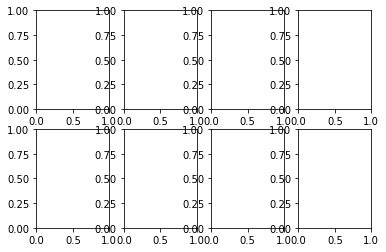

In [12]:

def files():

    img_dir = "../Resources/Glass"  # Enter Directory of all images
    data_path = os.path.join(img_dir, '*g')
    files = glob.glob(data_path)
    data = []
    for f1 in files:
        img = cv2.imread(f1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data.append(img)

    return data

batch = files()
neural = NeuralClass(batch, 0.1)
print(neural.detect())
print(neural.age())
columns = len(neural.faces)
rows = 2
fig, ax = plt.subplots(rows, columns)
res = neural.prediction
print(res)

In [14]:
res


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Brown Hair,Bald,No eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Curly Hair,Wavy Hair,Straight Hair
0,0.952401,0.032125,0.798524,0.001379,0.000782,0.093602,0.395710,0.092588,0.001784,0.314265,...,0.761162,0.006245,NaN,0.105743,0.059400,0.122644,0.297902,0.708687,0.075104,0.593477
1,0.991281,0.006199,0.030628,0.789679,0.002816,0.024945,0.025207,0.104780,0.012962,0.254340,...,0.339172,0.150731,NaN,0.128160,0.012985,0.905334,0.139992,0.374553,0.097960,0.793801
2,0.083391,0.004371,0.921588,0.005043,0.004099,0.071266,0.442016,0.006389,0.021162,0.009214,...,0.456426,0.005834,NaN,0.024025,0.014572,0.003502,0.567727,0.420912,0.878858,0.118213
3,0.933357,0.013947,0.794966,0.000915,0.001097,0.035093,0.363108,0.206236,0.002700,0.322117,...,0.820311,0.004901,NaN,0.395133,0.040206,0.353324,0.448175,0.659016,0.043570,0.571442


In [73]:
race = []
gender = []
glasses = []
age = []
hair = []
for row in res.iterrows():
    ##print("{}\n\n".format(row))
    race.append(np.argmax(row[1][1:4]))
    gender.append('male' if row[1]['Male']>0.5 else 'female')
    age.append(np.argmax(row[1][4:9]))
    hair.append(np.argmax(row[1][9:13]))
    glasses.append([row[1][13],np.argmax(row[1][13:16])])

In [74]:
race,age,gender,hair,glasses

(['Black', 'White', 'Black'],
 ['Middle Aged', 'Youth', 'Child'],
 ['male', 'female', 'male'],
 ['Brown Hair', 'Brown Hair', 'Brown Hair'],
 [[nan, 'Eyeglasses'], [nan, 'Eyeglasses'], [nan, 'Eyeglasses']])

In [94]:
from collections import Counter

raceP = Counter(race)
print len(race)
print (raceP.most_common()[0][1])


3
2
